# "An RL Approach for Inventory Management (Part 10)"

> Tabular Temporal-Difference (SARSA) Control
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement10.png
- categories: [Inventory_Management,   Markov_Decision_Process,   TD,SARSA]
- show_tags: true

In [1]:
# hide
# based on 0^td_simple_inventory_mdp_cap_KE.ipynb

## 1 Generalized Policy Iteration (GPI)

In previous projects we have only dealt with the *prediction* problem. In this project we move on to the *control* problem. We stay in the *model-free* or *learning* domain (rather than *planning*), i.e. making use of Reinforcement Learning algorithms. We will explore the *depth of update* dimension, considering both *bootstrapping* and *non-bootstrapping* methods like Temporal-Difference (TD) and Monte-Carlo (MC) algorithms respectively.

What is different about Control, rather than Prediction, is the depence on the concept of Generalized Policy Iteration (GPI). 

The key concept of GPI is that we can:
- Evaluate a policy with *any* Policy Evaluation method
- Improve a policy with *any* Policy Improvement method

## 2 GPI with Evaluation as Monte-Carlo (MC)

Here is a reasonable way to approach MC Control based on what we have done so far:
- do MC Policy Evaluation (which is essentially MC Prediction)
- do greedy Policy Improvement
- do MC Policy Evaluation on the improved policy
- etc., etc.

However, this naive approach leads to some complications.

### 2.1 Greedy Policy Improvement requires $\mathcal P$ and $\mathcal R$

The first complication is that:
- Greedy Policy Improvement requires the 
  - state transition probability function $\mathcal P$
  - reward function $\mathcal R$
This is not available in the model-free domain. (They were, however, available in the model-based domain when we performed dynamic programming).

We address this complication by noting that

$$
\pi'_D(s) = \underset{a \in \mathcal A}{\text{arg max}} \{\mathcal R(s, a) + \gamma \sum_{s' \in \mathcal N}\mathcal P(s, a, s') \cdot V^\pi(s')\} \text{ for all } s \in \mathcal N
$$

can be expressed more concisely as:

$$
\pi'_D(s) = \underset{a \in \mathcal A}{\text{arg max}} Q^\pi(s, a) \text{ for all } s \in \mathcal N
$$

This is valuable because:
- Instead of doing 
  - Policy Evaluation to calculate $V^\pi$
- We do 
  - Policy Evaluation to calculate $Q^\pi$ (i.e. MC Prediction for the Action Value Function, $Q$)


### 2.2 Biased initial random occurrences of returns

The second complication is that updates can get biased by initial random occurrences of returns. This could prevent certain actions from being sufficiently chosen. This will lead to inaccurate estimates of the action values for those actions. We want to *exploit* actions that provide better returns but at the same time also be sure to *explore* all possible actions. This problem is known as the *exploration-exploitation dilemma*.

The way to address this complication is to modify our Tabular MC Control algorithm:
- Instead of doing 
  - greedy Policy Improvement
- we want to do
  - $\epsilon$-greedy Policy Improvement

This impoved stochastic policy is defined as:

$$
\pi'(s, a) = 
\left\{
  \begin{array}{ll}
    \frac{\epsilon}{|\mathcal A|}+1-\epsilon & \mbox{if } a= \mbox{arg max}_{b \in \mathcal A} Q(s, b) \\
    \frac{\epsilon}{|\mathcal A|} & \mbox{otherwise}
  \end{array}
\right.
$$

This means the:
- *exploit* probability is: $1-\epsilon$
  - select the action that maximizes $Q$ for a given state
- *explore* probability is: $\epsilon$
  - uniform-randomly select an allowable action

The deterministic greedy policy $\pi'_D$ is a special case of the $\epsilon$-greedy policy $\pi'$. This happens when $\epsilon=0$.


In [3]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [4]:
!python --version

Python 3.7.15


In [5]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [6]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [7]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

In [8]:
from typing import Tuple, Callable, Sequence, Mapping, Iterator, Iterable, TypeVar, Set
import itertools
import inspect
from pprint import pprint
from operator import itemgetter

In [9]:
# hide
from rl.distribution_ANNO import (Constant, Choose, Categorical)
import rl.iterate_ANNO as iterate
from rl.markov_process_ANNO import NonTerminal
from rl.markov_decision_process_ANNO import (
    FiniteMarkovDecisionProcess, 
    MarkovDecisionProcess, 
    S, 
    A,
    Policy
)
from rl.dynamic_programming_ANNO import (value_iteration_result, V)
from rl.approximate_dynamic_programming_ANNO import (QValueFunctionApprox, NTStateDistribution)
from rl.function_approx_ANNO import (Tabular, learning_rate_schedule)
from rl.policy_ANNO import (
    FiniteDeterministicPolicy, 
    RandomPolicy, 
    DeterministicPolicy, 
    UniformPolicy
)
from rl.returns_ANNO import returns

from rl.book45_github3.simple_inventory_mdp_cap import (SimpleInventoryMDPCap, InventoryState)

## 3 Temporal-Difference (TD) Control (SARSA)

### 3.1 TD Control with TAB (Tabular)

With FAP TD, an update is made to the *parameters* of the Action Value Function $Q$ every time we transition from a state-action $(S_t, A_t)$ to state-action $(S_{t+1},A_{t+1})$ with reward $R_{t+1}$.

Let us consider again the Action Value Function update for MC (Monte-Carlo) Control in the TAB case:

$$
Q(S_t,A_t) ← Q(S_t,A_t) + \alpha ⋅ [G_t - Q(S_t,A_t)]
$$

To move from MC to TD we take advantage of the recursive structure of the Action Value Function in the MDP Bellman equation. We do this by forming an estimate for $G_t$ from $R_{t+1}$ and $Q(S_{t+1},A_{t+1})$. This means the update for TAB TD Control is:

$$
Q(S_t,A_t) ← Q(S_t,A_t) + \alpha ⋅ [R_{t+1} + \gamma \cdot Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)]
$$

where the

- TD Target is $R_{t+1} + \gamma \cdot Q(S_{t+1},A_{t+1})$
- TD Error is $\delta_t = R_{t+1} + \gamma \cdot Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)$






### 3.2 TD Control with FAP (Function Approximation)

To move from MC to TD we do the same type of replacement, i.e. we replace $G_t$ with $R_{t+1}+\gamma \cdot Q(S_{t+1},A_{t+1};w)$ in the expression for MC Control:

$$
\Delta w = \alpha \cdot [G_t - Q(S_t,A_t;w)] \cdot \nabla_wQ(S_t,A_t;w)
$$

This leads to the parameter update:

$$
\Delta w = \alpha \cdot [(R_{t+1}+\gamma \cdot Q(S_{t+1},A_{t+1};w))-Q(S_t,A_t;w)] \cdot \nabla_w Q(S_t,A_t;w) 
$$

### 3.3 Generalized implementation of GLIE Temporal_Difference (SARSA) Control

The following code can handle both TAB and FAP cases.

In [10]:
A = TypeVar('A')

def epsilon_greedy_action(
    q: QValueFunctionApprox[S, A],
    nt_state: NonTerminal[S],
    actions: Set[A],
    ϵ: float
) -> A:
    greedy_action: A = max(
        ((a, q((nt_state, a))) for a in actions),
        key=itemgetter(1)
    )[0]
    return Categorical(
        {a: ϵ / len(actions) +
         (1 - ϵ if a == greedy_action else 0.) for a in actions}
    ).sample()

In [11]:
def glie_sarsa(
    mdp: MarkovDecisionProcess[S, A],
    states: NTStateDistribution[S],
    approx_0: QValueFunctionApprox[S, A],
    γ: float,
    ϵ_as_func_of_episodes: Callable[[int], float],
    max_episode_length: int
) -> Iterator[QValueFunctionApprox[S, A]]:
    q: QValueFunctionApprox[S, A] = approx_0
    yield q
    num_episodes: int = 0
    while True:
        num_episodes += 1
        ϵ: float = ϵ_as_func_of_episodes(num_episodes)
        state: NonTerminal[S] = states.sample()
        action: A = epsilon_greedy_action(
            q=q,
            nt_state=state,
            actions=set(mdp.actions(state)),
            ϵ=ϵ
        )
        steps: int = 0
        while isinstance(state, NonTerminal) and steps < max_episode_length:
            #. next_state, reward = mdp.step(state, action).sample()
            next_state, reward = mdp.transition_action(state, action).sample() #.
            if isinstance(next_state, NonTerminal):
                next_action: A = epsilon_greedy_action(
                    q=q,
                    nt_state=next_state,
                    actions=set(mdp.actions(next_state)),
                    ϵ=ϵ
                )
                q = q.update([(
                    (state, action),
                    reward + γ * q((next_state, next_action))
                )])
                action = next_action
            else:
                q = q.update([((state, action), reward)])
            yield q
            steps += 1
            state = next_state

We run the GLIE TAB TD Control (SARSA) algorithm on the Inventory problem.

In [12]:
# hide
inspect.getmro(SimpleInventoryMDPCap)

(rl.book45_github3.simple_inventory_mdp_cap.SimpleInventoryMDPCap,
 rl.markov_decision_process_ANNO.FiniteMarkovDecisionProcess,
 rl.markov_decision_process_ANNO.MarkovDecisionProcess,
 abc.ABC,
 typing.Generic,
 object)

In [13]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0
gamma: float = 0.9

In [14]:
si_mdp: SimpleInventoryMDPCap = SimpleInventoryMDPCap(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

In [15]:
# mc_episode_length_tol: float = 1e-5
max_episode_length: int = 100
epsilon_as_func_of_episodes: Callable[[int], float] = lambda k: k**-0.5
initial_learning_rate: float = 0.1
half_life: float = 10000.0
exponent: float = 1.0
gamma: float = 0.9

In [16]:
initial_qvf_dict: Mapping[Tuple[NonTerminal[InventoryState], int], float] = {
    (s, a): 0. for s in si_mdp.non_terminal_states for a in si_mdp.actions(s)
}
initial_qvf_dict

{(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=1)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): 0.0}

In [17]:
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

In [18]:
qvfas: Iterator[QValueFunctionApprox[InventoryState, int]] = glie_sarsa(
    mdp=si_mdp, 
    states=Choose(si_mdp.non_terminal_states),
    approx_0=Tabular(
        values_map=initial_qvf_dict, 
        count_to_weight_func=learning_rate_func
    ), 
    γ=gamma, 
    ϵ_as_func_of_episodes=epsilon_as_func_of_episodes, 
    max_episode_length=max_episode_length
)
qvfas

<generator object glie_sarsa at 0x7f274564ea50>

Now we get the final estimate of the Optimal Action-Value Function after n_episodes*max_episode_length. Then we extract from it the estimate of the Optimal State-Value Function and the Optimal Policy.

In [19]:
n_episodes = 10_000
n_updates = n_episodes*max_episode_length

In [20]:
%%time
qvfa_lst = [qvfa for qvfa in itertools.islice(qvfas, n_updates)]

CPU times: user 1min 22s, sys: 1.23 s, total: 1min 24s
Wall time: 1min 24s


In [21]:
final_qvfa: QValueFunctionApprox[InventoryState, int] = iterate.last(qvfa_lst)

In [22]:
final_qvfa

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -41.52168739527937, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): -35.010040801683566, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): -35.502400675078896, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): -30.649937239183526, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): -27.838795349311173, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): -28.211255634891565, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 0): -33.24242269182834, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): -28.87802451931174, (NonTerminal(state=InventoryState(on_hand=1, on_order=1)), 0): -29.13100920569048, (NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): -29.962739881512658}, counts_map={(NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): 124557, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1

In [23]:
def get_vf_and_policy_from_qvf(
    mdp: FiniteMarkovDecisionProcess[S, A],
    qvf: QValueFunctionApprox[S, A]
) -> Tuple[V[S], FiniteDeterministicPolicy[S, A]]:
    opt_vf: V[S] = {
        s: max(qvf((s, a)) for a in mdp.actions(s))
        for s in mdp.non_terminal_states
    }
    opt_policy: FiniteDeterministicPolicy[S, A] = \
        FiniteDeterministicPolicy({
            s.state: qvf.argmax((s, a) for a in mdp.actions(s))[1]
            for s in mdp.non_terminal_states
        })
    return opt_vf, opt_policy

In [24]:
opt_svf, opt_pol = get_vf_and_policy_from_qvf(
    mdp=si_mdp,
    qvf=final_qvfa
)

In [25]:
print(f"GLIE TD (SARSA) Optimal Value Function with {n_updates:d} updates")
pprint(opt_svf)

GLIE TD (SARSA) Optimal Value Function with 1000000 updates
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.010040801683566,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.838795349311173,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.211255634891565,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.87802451931174,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.13100920569048,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.962739881512658}


In [26]:
print(f"GLIE TD (SARSA) Optimal Policy with {n_updates:d} updates")
pprint(opt_pol)

GLIE TD (SARSA) Optimal Policy with 1000000 updates
For State InventoryState(on_hand=0, on_order=0): Do Action 1
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0



For comparison, we run a Value Iteration to find the *true* Optimal Value Function and Optimal Policy.

In [27]:
true_opt_svf, true_opt_pol = value_iteration_result(mdp=si_mdp, gamma=gamma)

In [28]:
print("True Optimal State Value Function")
pprint(true_opt_svf)

True Optimal State Value Function
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -34.894855194671294,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.66095964467877,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -27.99189950444479,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.66095964467877,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -28.99189950444479,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.991899504444792}


In [29]:
print("True Optimal Policy")
pprint(true_opt_pol)

True Optimal Policy
For State InventoryState(on_hand=0, on_order=0): Do Action 1
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0



Now we compare values by state for the State Value Function

In [30]:
[(true_opt_svf[s], opt_svf[s]) for s in si_mdp.non_terminal_states]

[(-34.894855194671294, -35.010040801683566),
 (-27.66095964467877, -27.838795349311173),
 (-27.99189950444479, -28.211255634891565),
 (-28.66095964467877, -28.87802451931174),
 (-28.99189950444479, -29.13100920569048),
 (-29.991899504444792, -29.962739881512658)]

We also compare values by state for the Policy

In [31]:
[(true_opt_pol.policy_map[s.state], opt_pol.policy_map[s.state]) for s in si_mdp.non_terminal_states]

[(Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0))]

### 3.4 Visualize

Let us visualize the convergence of the Action Value Function (Q) for each of the states:

In [32]:
qvfa_lst[10]

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): -1.9015298470152984, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): -0.36787944117144233, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): -0.06781910479713896, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 0): -0.46787944117144237, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): -0.46787944117144237, (NonTerminal(state=InventoryState(on_hand=1, on_order=1)), 0): 0.0, (NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): -0.5736009634179852}, counts_map={(NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): 2, (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): 1, (NonTerminal(state=InventoryState(on_hand=0, on_order=1

In [33]:
qvfa_lst[10].values_map

{(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
  2): -1.9015298470152984,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
  1): -0.36787944117144233,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)),
  0): -0.06781910479713896,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)),
  0): -0.46787944117144237,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)),
  1): -0.46787944117144237,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=1)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=0)),
  0): -0.5736009634179852}

In [34]:
qvfa_lst[10].counts_map

{(NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 0): 2,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 2,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): 2}

Let us visualize how the Action Value Function for each (state, action) pair converges during the operation of the Monte-Carlo algorithm.

In [35]:
values_dicts = [(vfa.values_map) for vfa in qvfa_lst]
# values_dicts

In [36]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = values_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [37]:
len(merged_dict)

10

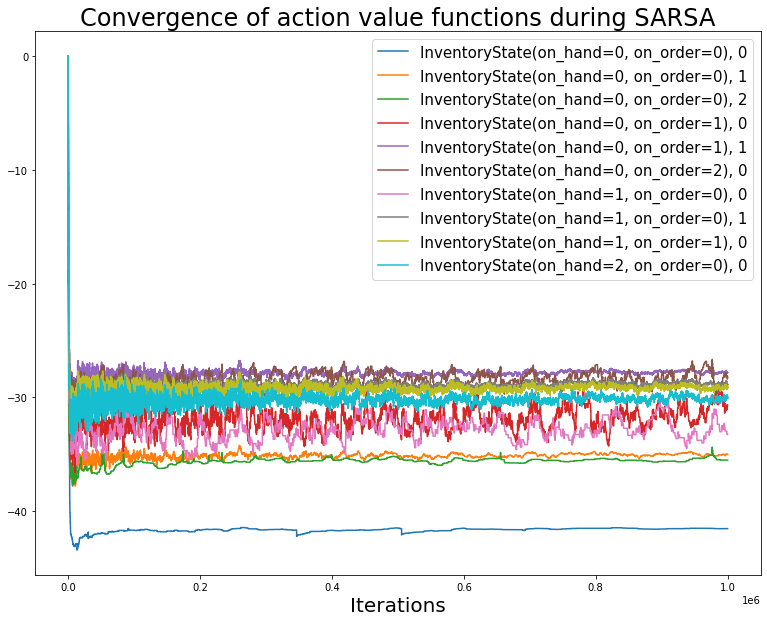

In [38]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Convergence of action value functions during SARSA', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
axs.legend(fontsize=15);

Next we visualize the number of visits for each (state, action) pair during the operation of the Monte-Carlo algorithm.

In [39]:
counts_dicts = [(vfa.counts_map) for vfa in qvfa_lst]
# values_dicts

In [40]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = counts_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [41]:
len(merged_dict)

10

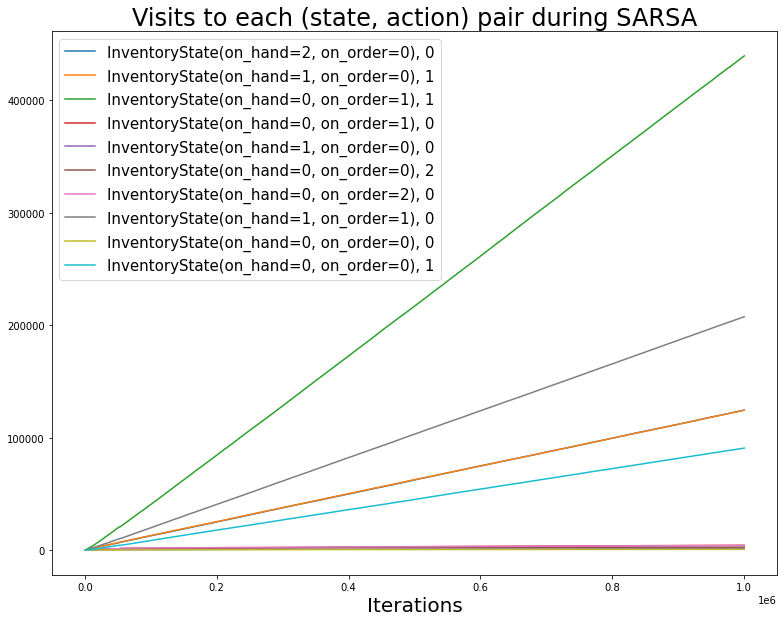

In [42]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Visits to each (state, action) pair during SARSA', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
axs.legend(fontsize=15);

In [ ]:
# hide
# q_learning_epsilon: float = 0.2
# td_episode_length: int = 100

In [ ]:
# hide
# %%time
# glie_mc_finite_learning_rate_correctness(
#     fmdp=si_mdp,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     gamma=gamma,
#     epsilon_as_func_of_episodes=epsilon_as_func_of_episodes,
#     episode_length_tolerance=mc_episode_length_tol,
#     num_episodes=num_episodes
# )

In [ ]:
# hide
# %%time
# glie_sarsa_finite_learning_rate_correctness(
#     fmdp=si_mdp,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     gamma=gamma,
#     epsilon_as_func_of_episodes=epsilon_as_func_of_episodes,
#     max_episode_length=td_episode_length,
#     num_updates=num_episodes * td_episode_length
# )

In [ ]:
# hide
# %%time
# q_learning_finite_learning_rate_correctness(
#     fmdp=si_mdp,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     gamma=gamma,
#     epsilon=q_learning_epsilon,
#     max_episode_length=td_episode_length,
#     num_updates=num_episodes * td_episode_length
# )

In [ ]:
# hide
# num_episodes = 500
# plot_batch: int = 10
# plot_start: int = 0
# learning_rates: Sequence[Tuple[float, float, float]] = \
#     [(0.05, 1000000, 0.5)]

In [ ]:
# hide
# compare_mc_sarsa_ql(
#     fmdp=si_mdp,
#     method_mask=[True, True, False],
#     learning_rates=learning_rates,
#     gamma=gamma,
#     epsilon_as_func_of_episodes=epsilon_as_func_of_episodes,
#     q_learning_epsilon=q_learning_epsilon,
#     mc_episode_length_tol=mc_episode_length_tol,
#     num_episodes=num_episodes,
#     plot_batch=plot_batch,
#     plot_start=plot_start
# )